
#The implementation of different LSTM models including Encoder-Decoder based approaches for Rainfall-Runoff Modeling for Awash River in Ethiopia.


The data used to model the system are the streamflow, precipitation, temperature, wind speed, and humudity at different guaging stations in the upper Awash river basin. 28 years of daily recorded data is used.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Import Libraries

In [ ]:
import pandas as pd
import datetime as dt  # Python standard library datetime  module
import matplotlib.pyplot as plt
import keras
from pandas import read_csv,concat,DataFrame,datetime
import numpy
import numpy as np
from numpy import concatenate

import math
from math import sqrt

from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,mean_squared_error,mean_absolute_error

from tensorflow.keras import regularizers,optimizers
from tensorflow.keras.layers import BatchNormalization,Dense, Dropout, LSTM, GRU, TimeDistributed, Input, RNN,GRUCell,Lambda,Bidirectional,Concatenate,LSTMCell
from tensorflow.keras.models import Sequential,Model
from keras.callbacks import Callback
from tensorflow.keras import backend as K

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.8.2'

In [ ]:
tf.test.is_gpu_available()    #Tru if Gpu is avalible

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
!cat /proc/cpuinfo # Check the processing hardware

# Data preparation and processing

The Path below goes to my mounted GoogleDrive - It should be changed based on your GoogleDrive directory.

In [ ]:
path= "/content/drive/MyDrive/1981_final/"

The Datasets were slightly modified before uploading them.

1) Missing data was replaced by taking the average of previous 3 years on similar date of record.

#Stream flow data for 3 stations 1) Berga station 2)Akaki Station 3) Hombole station (this is the target station to predict future streamflow)

In [ ]:
sf_berga = pd.read_csv(path + 'berga.csv')
sf_akaki = pd.read_csv(path + 'Akaki.csv')
sf_hom = pd.read_csv(path + 'hombole.csv')

#Precipitation at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sebeta 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11) Ginchi

In [ ]:
pcp_aa = pd.read_csv(path + 'pcp_aa.csv') # preciptation at addis ababa station
pcp_hom = pd.read_csv(path + 'pcp_hom.csv') # preciptation at hombole station
pcp_asgori = pd.read_csv(path + 'pcp_asgori.csv') # preciptation at asgori station
pcp_sendefa = pd.read_csv(path + 'pcp_sendefa.csv') # preciptation at sendefa station
pcp_tulubolo = pd.read_csv(path + 'pcp_tulubolo.csv') # preciptation at tulubolo station

pcp_sebeta = pd.read_csv(path + 'pcp_sebeta.csv') # preciptation at sebeta station
pcp_aalem = pd.read_csv(path + 'pcp_aalem.csv') # preciptation at addis alem station
pcp_boneya = pd.read_csv(path + 'pcp_boneya.csv') # preciptation at boneya station
pcp_kimoye = pd.read_csv(path + 'pcp_kimoye.csv') # preciptation at kimoye station
pcp_guranda = pd.read_csv(path + 'pcp_guranda.csv') # preciptation at guranda meta station

pcp_ginchi = pd.read_csv(path + 'pcp_ginchi.csv') # preciptation at ginchi station

#Average of (min and max) temprature at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sendefa 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11)11) Ginchi

In [ ]:
temp_aa = pd.read_csv(path + 'tmp_aa.csv') # temprature at addis ababa station
temp_hom = pd.read_csv(path + 'tmp_hom.csv') # preciptation at hombole station
temp_asgori = pd.read_csv(path + 'tmp_asgori.csv') # preciptation at asgori station
temp_sendefa = pd.read_csv(path + 'tmp_sendefa.csv') # preciptation at sendefa station
temp_tulubolo = pd.read_csv(path + 'tmp_tulubolo.csv') # preciptation at tulubolo station

temp_sebeta = pd.read_csv(path + 'tmp_sebeta.csv') # preciptation at sebeta station
temp_aalem = pd.read_csv(path + 'tmp_aalem.csv') # preciptation at addis alem station
temp_boneya = pd.read_csv(path + 'tmp_boneya.csv') # preciptation at boneya station
temp_kimoye = pd.read_csv(path + 'tmp_kimoye.csv') # preciptation at kimoye station
temp_guranda = pd.read_csv(path + 'tmp_guranda.csv') # preciptation at guranda meta station

temp_ginchi = pd.read_csv(path + 'tmp_ginchi.csv') # preciptation at ginchi station

In [ ]:
temp_hom.head()

,DATE,avg_temp
0,1/1/1981,20.20
1,1/2/1981,20.10
2,1/3/1981,20.10
3,1/4/1981,20.15
4,1/5/1981,20.75


#Humudity at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sendefa 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11)11) Ginchi

In [ ]:
hmd_aa = pd.read_csv(path + 'hmd_aa.csv') # humudity at addis ababa station
hmd_hom = pd.read_csv(path + 'hmd_hom.csv') # preciptation at hombole station
hmd_asgori = pd.read_csv(path + 'hmd_asgori.csv') # preciptation at asgori station
hmd_sendefa = pd.read_csv(path + 'hmd_sendefa.csv') # preciptation at sendefa station
hmd_tulubolo = pd.read_csv(path + 'hmd_tulubolo.csv') # preciptation at tulubolo station

hmd_sebeta = pd.read_csv(path + 'hmd_sebeta.csv') # preciptation at sebeta station
hmd_aalem = pd.read_csv(path + 'hmd_aalem.csv') # preciptation at addis alem station
hmd_boneya = pd.read_csv(path + 'hmd_boneya.csv') # preciptation at boneya station
hmd_kimoye = pd.read_csv(path + 'hmd_kimoye.csv') # preciptation at kimoye station
hmd_guranda = pd.read_csv(path + 'hmd_guranda.csv') # preciptation at guranda meta station

hmd_ginchi = pd.read_csv(path + 'hmd_ginchi.csv') # preciptation at ginchi station

#Wind Speed at 11 stations 1) Addis ababa 2) Hombole 3) Asgori 4) Sendefa 5) Tulubolo 6)Sendefa 7)Addis Alem 8) Boneya 9) Kimoye 10) Guranda 11)11) Ginchi

In [ ]:
wnd_aa = pd.read_csv(path + 'wnd_aa.csv') # wind speed at addis ababa station
wnd_hom = pd.read_csv(path + 'wnd_hom.csv') # preciptation at hombole station
wnd_asgori = pd.read_csv(path + 'wnd_asgori.csv') # preciptation at asgori station
wnd_sendefa = pd.read_csv(path + 'wnd_sendefa.csv') # preciptation at sendefa station
wnd_tulubolo = pd.read_csv(path + 'wnd_tulubolo.csv') # preciptation at tulubolo station

wnd_sebeta = pd.read_csv(path + 'wnd_sebeta.csv') # preciptation at sebeta station
wnd_aalem = pd.read_csv(path + 'wnd_aalem.csv') # preciptation at addis alem station
wnd_boneya = pd.read_csv(path + 'wnd_boneya.csv') # preciptation at boneya station
wnd_kimoye = pd.read_csv(path + 'wnd_kimoye.csv') # preciptation at kimoye station
wnd_guranda = pd.read_csv(path + 'wnd_guranda.csv') # preciptation at guranda meta station

wnd_ginchi = pd.read_csv(path + 'wnd_ginchi.csv') # preciptation at ginchi station

#Make date as index

In [ ]:
## format datetime column
sf_hom["date"] = pd.to_datetime(sf_hom['date'])
sf_hom = sf_hom.set_index(['date'])
sf_berga["date"] = pd.to_datetime(sf_berga['date'])
sf_berga = sf_berga.set_index(['date'])
sf_akaki["date"] = pd.to_datetime(sf_akaki['date'])
sf_akaki = sf_akaki.set_index(['date'])

## format datetime column
pcp_aa["date"] = pd.to_datetime(pcp_aa['date'])
pcp_aa = pcp_aa.set_index(['date'])
pcp_hom["date"] = pd.to_datetime(pcp_hom['date'])
pcp_hom = pcp_hom.set_index(['date'])
pcp_asgori["date"] = pd.to_datetime(pcp_asgori['date'])
pcp_asgori = pcp_asgori.set_index(['date'])
pcp_sendefa["date"] = pd.to_datetime(pcp_sendefa['date'])
pcp_sendefa = pcp_sendefa.set_index(['date'])
pcp_tulubolo["date"] = pd.to_datetime(pcp_tulubolo['date'])
pcp_tulubolo = pcp_tulubolo.set_index(['date'])
pcp_sebeta["date"] = pd.to_datetime(pcp_sebeta['date'])
pcp_sebeta = pcp_sebeta.set_index(['date'])
pcp_aalem["date"] = pd.to_datetime(pcp_aalem['date'])
pcp_aalem = pcp_aalem.set_index(['date'])
pcp_boneya["date"] = pd.to_datetime(pcp_boneya['date'])
pcp_boneya = pcp_boneya.set_index(['date'])
pcp_kimoye["date"] = pd.to_datetime(pcp_kimoye['date'])
pcp_kimoye = pcp_kimoye.set_index(['date'])
pcp_guranda["date"] = pd.to_datetime(pcp_guranda['date'])
pcp_guranda = pcp_guranda.set_index(['date'])
pcp_ginchi["date"] = pd.to_datetime(pcp_ginchi['date'])
pcp_ginchi = pcp_ginchi.set_index(['date'])
## 
temp_aa["date"] = pd.to_datetime(temp_aa['date'])
temp_aa = temp_aa.set_index(['date'])
temp_hom["DATE"] = pd.to_datetime(temp_hom['DATE'])
temp_hom = temp_hom.set_index(['DATE'])
temp_asgori["date"] = pd.to_datetime(temp_asgori['date'])
temp_asgori = temp_asgori.set_index(['date'])
temp_sendefa["date"] = pd.to_datetime(temp_sendefa['date'])
temp_sendefa = temp_sendefa.set_index(['date'])
temp_tulubolo["date"] = pd.to_datetime(temp_tulubolo['date'])
temp_tulubolo = temp_tulubolo.set_index(['date'])
temp_sebeta["date"] = pd.to_datetime(temp_sebeta['date'])
temp_sebeta = temp_sebeta.set_index(['date'])
temp_aalem["date"] = pd.to_datetime(temp_aalem['date'])
temp_aalem = temp_aalem.set_index(['date'])
temp_boneya["date"] = pd.to_datetime(temp_boneya['date'])
temp_boneya = temp_boneya.set_index(['date'])
temp_kimoye["date"] = pd.to_datetime(temp_kimoye['date'])
temp_kimoye = temp_kimoye.set_index(['date'])
temp_guranda["date"] = pd.to_datetime(temp_guranda['date'])
temp_guranda = temp_guranda.set_index(['date'])
temp_ginchi["date"] = pd.to_datetime(temp_ginchi['date'])
temp_ginchi = temp_ginchi.set_index(['date'])
## 
hmd_aa["date"] = pd.to_datetime(hmd_aa['date'])
hmd_aa = hmd_aa.set_index(['date'])
hmd_hom["date"] = pd.to_datetime(hmd_hom['date'])
hmd_hom = hmd_hom.set_index(['date'])
hmd_asgori["date"] = pd.to_datetime(hmd_asgori['date'])
hmd_asgori = hmd_asgori.set_index(['date'])
hmd_sendefa["date"] = pd.to_datetime(hmd_sendefa['date'])
hmd_sendefa = hmd_sendefa.set_index(['date'])
hmd_tulubolo["date"] = pd.to_datetime(hmd_tulubolo['date'])
hmd_tulubolo = hmd_tulubolo.set_index(['date'])
hmd_sebeta["date"] = pd.to_datetime(hmd_sebeta['date'])
hmd_sebeta = hmd_sebeta.set_index(['date'])
hmd_aalem["date"] = pd.to_datetime(hmd_aalem['date'])
hmd_aalem = hmd_aalem.set_index(['date'])
hmd_boneya["date"] = pd.to_datetime(hmd_boneya['date'])
hmd_boneya = hmd_boneya.set_index(['date'])
hmd_kimoye["date"] = pd.to_datetime(hmd_kimoye['date'])
hmd_kimoye = hmd_kimoye.set_index(['date'])
hmd_guranda["date"] = pd.to_datetime(hmd_guranda['date'])
hmd_guranda = hmd_guranda.set_index(['date'])
hmd_ginchi["date"] = pd.to_datetime(hmd_ginchi['date'])
hmd_ginchi = hmd_ginchi.set_index(['date'])
## 
wnd_aa["date"] = pd.to_datetime(wnd_aa['date'])
wnd_aa = wnd_aa.set_index(['date'])
wnd_hom["date"] = pd.to_datetime(wnd_hom['date'])
wnd_hom = wnd_hom.set_index(['date'])
wnd_asgori["date"] = pd.to_datetime(wnd_asgori['date'])
wnd_asgori = wnd_asgori.set_index(['date'])
wnd_sendefa["date"] = pd.to_datetime(wnd_sendefa['date'])
wnd_sendefa = wnd_sendefa.set_index(['date'])
wnd_tulubolo["date"] = pd.to_datetime(wnd_tulubolo['date'])
wnd_tulubolo = wnd_tulubolo.set_index(['date'])
wnd_sebeta["date"] = pd.to_datetime(wnd_sebeta['date'])
wnd_sebeta = wnd_sebeta.set_index(['date'])
wnd_aalem["date"] = pd.to_datetime(wnd_aalem['date'])
wnd_aalem = wnd_aalem.set_index(['date'])
wnd_boneya["date"] = pd.to_datetime(wnd_boneya['date'])
wnd_boneya = wnd_boneya.set_index(['date'])
wnd_kimoye["date"] = pd.to_datetime(wnd_kimoye['date'])
wnd_kimoye = wnd_kimoye.set_index(['date'])
wnd_guranda["date"] = pd.to_datetime(wnd_guranda['date'])
wnd_guranda = wnd_guranda.set_index(['date'])
wnd_ginchi["date"] = pd.to_datetime(wnd_ginchi['date'])
wnd_ginchi = wnd_ginchi.set_index(['date'])

In [ ]:
# print("Stream Flow description:\n", sf_hom.describe(), "\n")
# print("Precipitation description:\n", pcp_aa.describe(), "\n")

# print("Temperature description:\n", temp_aa.describe(), "\n")

# print("Humudity description:\n",hmd_aa.describe(), "\n")
# print("Wind speed description:\n",wnd_aa.describe(), "\n")

#Convert to floating point values 

In [ ]:
sf_hom['streamflow']=sf_hom['streamflow'].astype(float)
sf_akaki['streamflow']=sf_akaki['streamflow'].astype(float)
sf_berga['streamflow']=sf_berga['streamflow'].astype(float)

pcp_aa['PCP']=pcp_aa['PCP'].astype(float)
pcp_hom['PCP']=pcp_hom['PCP'].astype(float)
pcp_asgori['PCP']=pcp_asgori['PCP'].astype(float)
pcp_sendefa['PCP']=pcp_sendefa['PCP'].astype(float)
pcp_tulubolo['PCP']=pcp_tulubolo['PCP'].astype(float)
pcp_sebeta['PCP']=pcp_sebeta['PCP'].astype(float)
pcp_aalem['PCP']=pcp_aalem['PCP'].astype(float)
pcp_boneya['PCP']=pcp_boneya['PCP'].astype(float)
pcp_kimoye['PCP']=pcp_kimoye['PCP'].astype(float)
pcp_guranda['PCP']=pcp_guranda['PCP'].astype(float)
pcp_ginchi['PCP']=pcp_ginchi['PCP'].astype(float)


temp_aa['avg_temp']=temp_aa['avg_temp'].astype(float)
temp_hom['avg_temp']=temp_hom['avg_temp'].astype(float)
temp_asgori['avg_temp']=temp_asgori['avg_temp'].astype(float)
temp_sendefa['avg_temp']=temp_sendefa['avg_temp'].astype(float)
temp_tulubolo['avg_temp']=temp_tulubolo['avg_temp'].astype(float)
temp_sebeta['avg_temp']=temp_sebeta['avg_temp'].astype(float)
temp_aalem['avg_temp']=temp_aalem['avg_temp'].astype(float)
temp_boneya['avg_temp']=temp_boneya['avg_temp'].astype(float)
temp_kimoye['avg_temp']=temp_kimoye['avg_temp'].astype(float)
temp_guranda['avg_temp']=temp_guranda['avg_temp'].astype(float)
temp_ginchi['avg_temp']=temp_ginchi['avg_temp'].astype(float)


hmd_aa['HMD']=hmd_aa['HMD'].astype(float)
hmd_hom['HMD']=hmd_hom['HMD'].astype(float)
hmd_asgori['HMD']=hmd_asgori['HMD'].astype(float)
hmd_sendefa['HMD']=hmd_sendefa['HMD'].astype(float)
hmd_tulubolo['HMD']=hmd_tulubolo['HMD'].astype(float)
hmd_sebeta['HMD']=hmd_sebeta['HMD'].astype(float)
hmd_aalem['HMD']=hmd_aalem['HMD'].astype(float)
hmd_boneya['HMD']=hmd_boneya['HMD'].astype(float)
hmd_kimoye['HMD']=hmd_kimoye['HMD'].astype(float)
hmd_guranda['HMD']=hmd_guranda['HMD'].astype(float)
hmd_ginchi['HMD']=hmd_ginchi['HMD'].astype(float)

wnd_aa['WND']=wnd_aa['WND'].astype(float)
wnd_hom['WND']=wnd_hom['WND'].astype(float)
wnd_asgori['WND']=wnd_asgori['WND'].astype(float)
wnd_sendefa['WND']=wnd_sendefa['WND'].astype(float)
wnd_tulubolo['WND']=wnd_tulubolo['WND'].astype(float)
wnd_sebeta['WND']=wnd_sebeta['WND'].astype(float)
wnd_aalem['WND']=wnd_aalem['WND'].astype(float)
wnd_boneya['WND']=wnd_boneya['WND'].astype(float)
wnd_kimoye['WND']=wnd_kimoye['WND'].astype(float)
wnd_guranda['WND']=wnd_guranda['WND'].astype(float)
wnd_ginchi['WND']=wnd_ginchi['WND'].astype(float)



#Stream flow plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7f15d4736e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f15d517a9d0>)

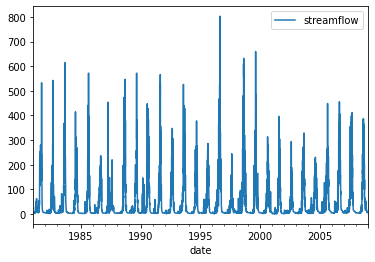

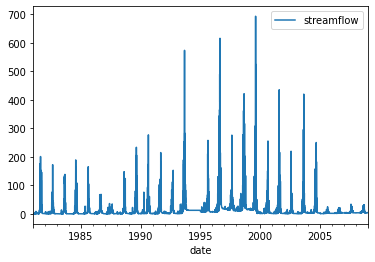

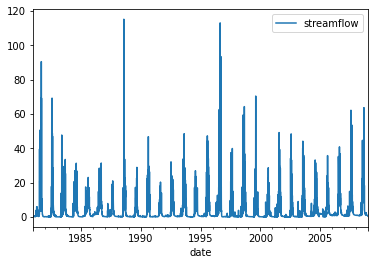

In [ ]:
sf_hom.plot(), sf_akaki.plot(), sf_berga.plot()

#Precipitation plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7f15d4580c50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f15d3ea9650>)

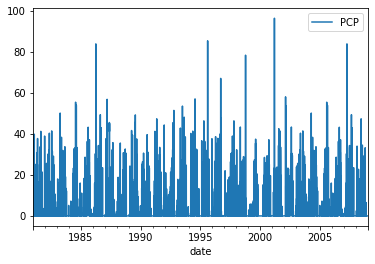

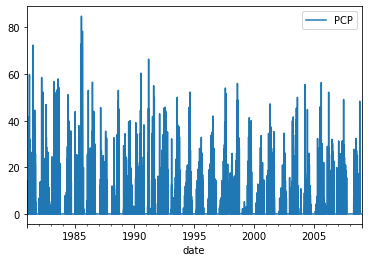

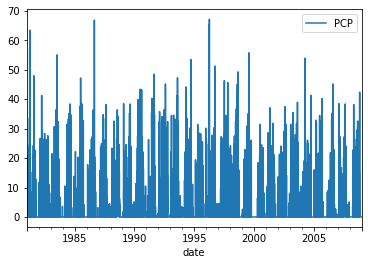

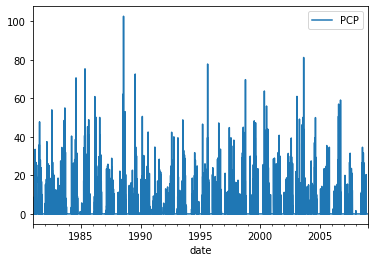

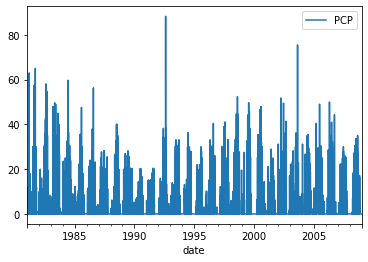

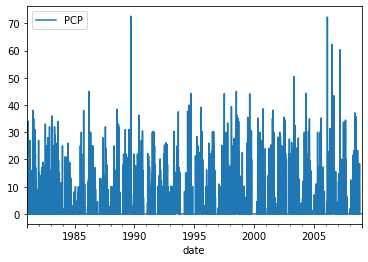

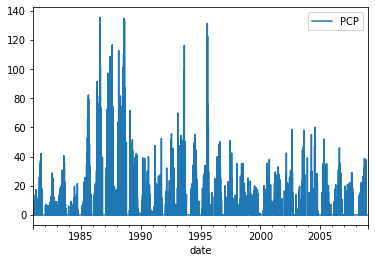

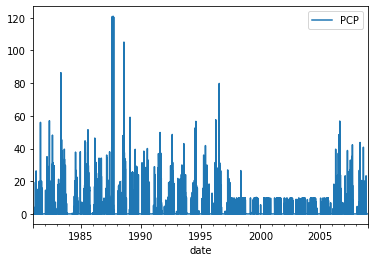

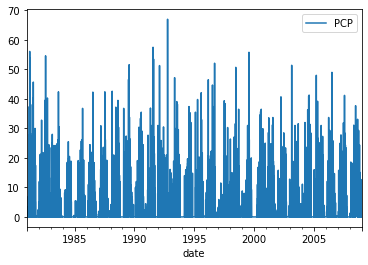

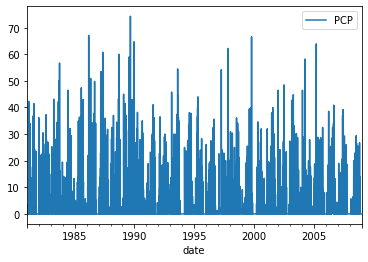

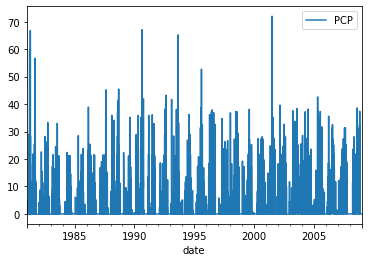

In [ ]:
pcp_aa.plot(), pcp_hom.plot(),pcp_asgori.plot(),pcp_sendefa.plot(),pcp_tulubolo.plot(),pcp_aalem.plot(), pcp_sebeta.plot(),pcp_boneya.plot(),pcp_kimoye.plot(),pcp_ginchi.plot(),pcp_guranda.plot()

#Tempature Plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7f15d44b8310>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f15d204b1d0>)

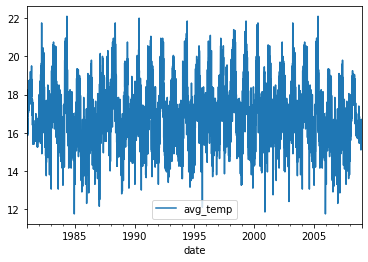

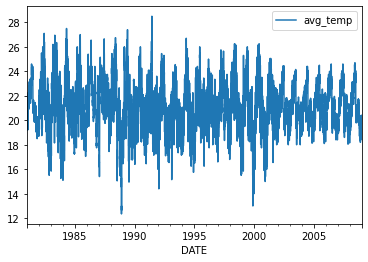

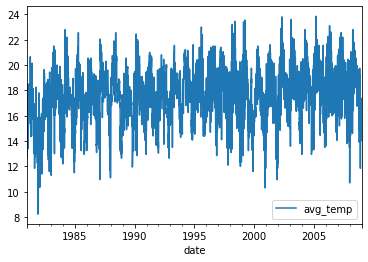

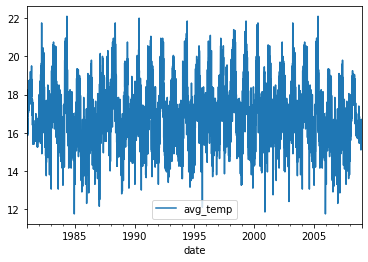

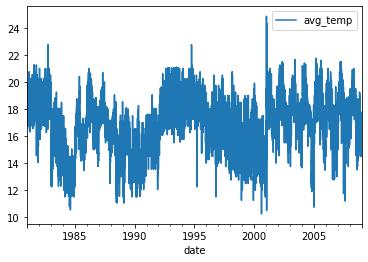

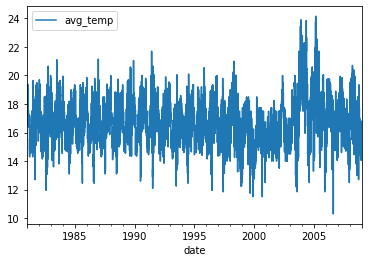

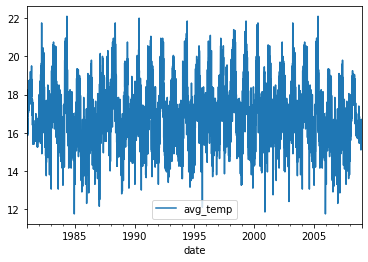

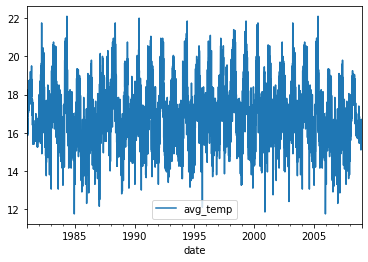

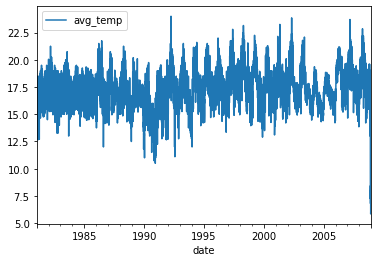

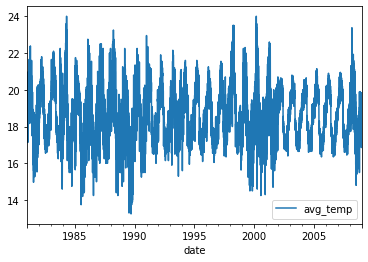

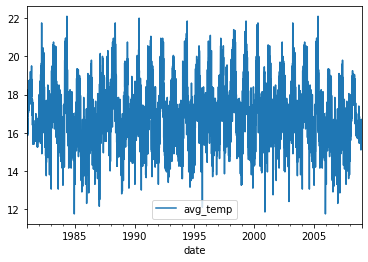

In [ ]:
temp_aa.plot(), temp_hom.plot(),temp_asgori.plot(),temp_sendefa.plot(),temp_tulubolo.plot(),temp_aalem.plot(), temp_sebeta.plot(),temp_boneya.plot(),temp_kimoye.plot(),temp_ginchi.plot(),temp_guranda.plot()

#Humudity Plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7f15d4106ed0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f15d0af2bd0>)

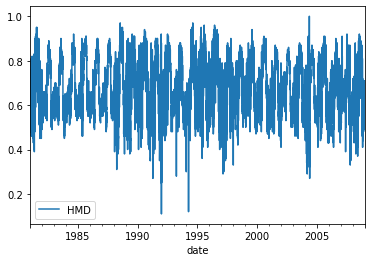

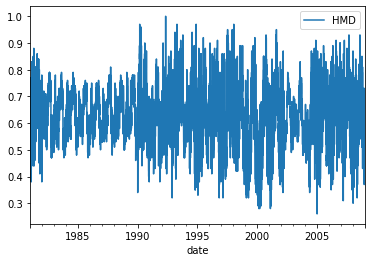

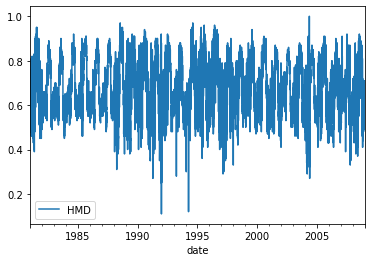

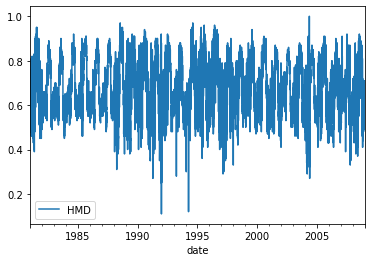

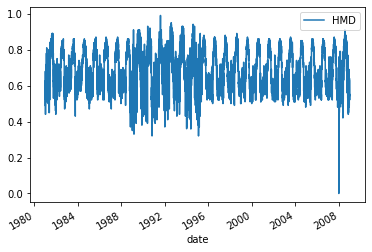

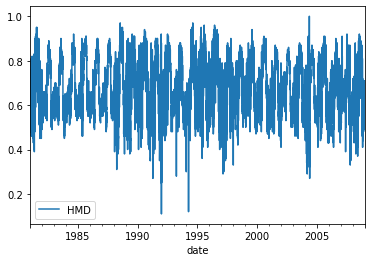

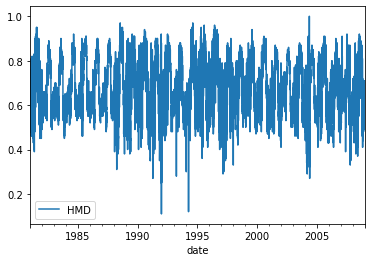

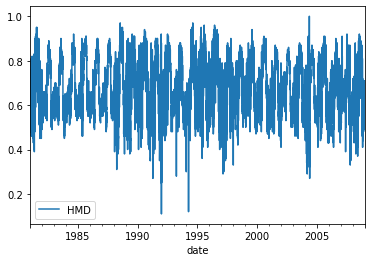

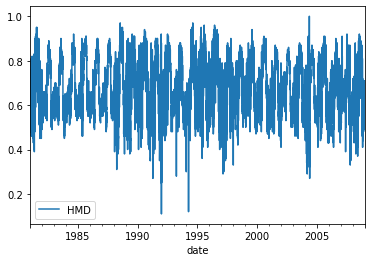

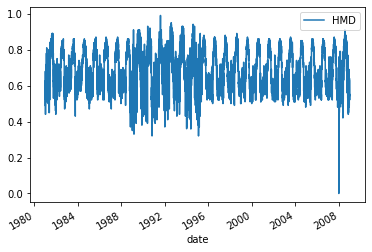

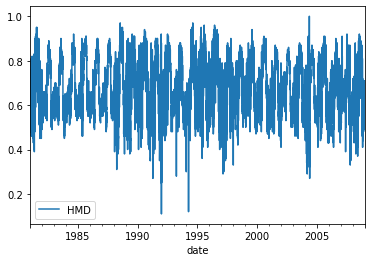

In [ ]:
hmd_aa.plot(), hmd_hom.plot(),hmd_asgori.plot(),hmd_sendefa.plot(),hmd_tulubolo.plot(),hmd_aalem.plot(), hmd_sebeta.plot(),hmd_boneya.plot(),hmd_kimoye.plot(),hmd_ginchi.plot(),hmd_guranda.plot()

#wind plots

(<matplotlib.axes._subplots.AxesSubplot at 0x7f15d07396d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f15d07c3310>)

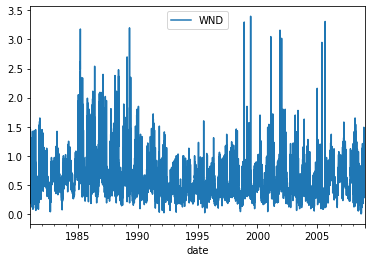

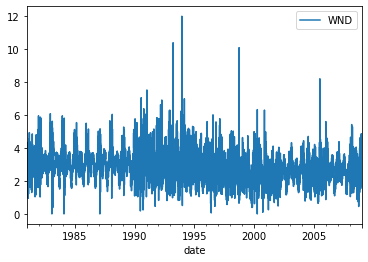

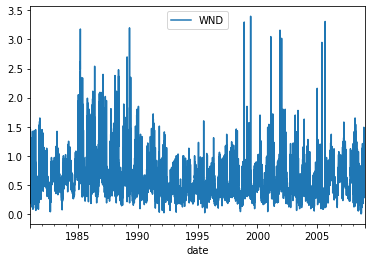

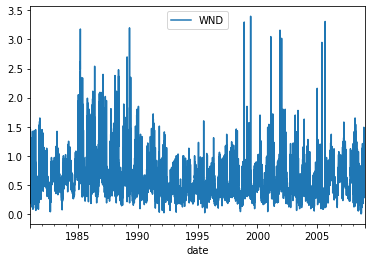

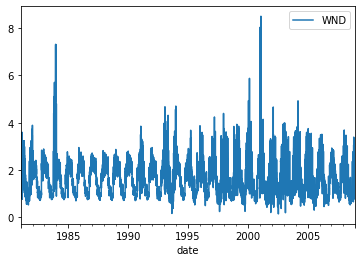

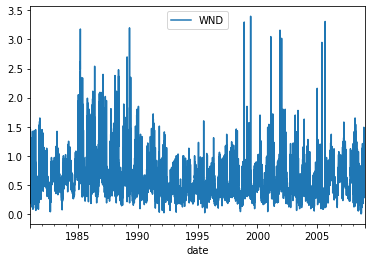

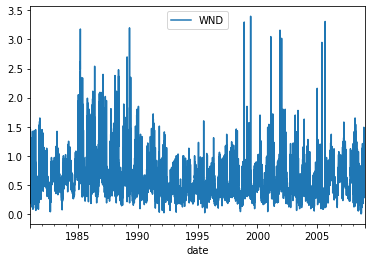

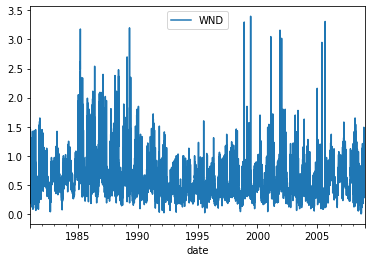

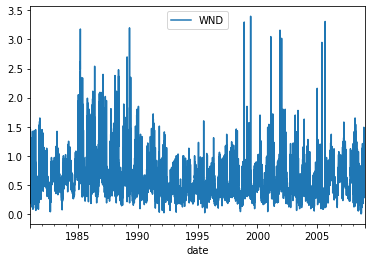

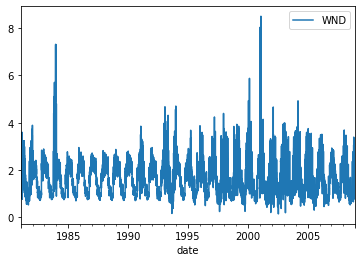

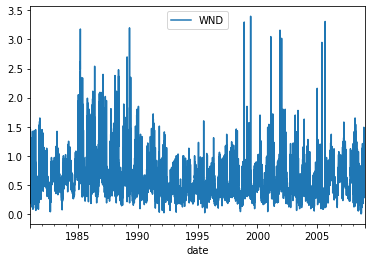

In [ ]:
wnd_aa.plot(),wnd_hom.plot(),wnd_asgori.plot(),wnd_sendefa.plot(),wnd_tulubolo.plot(),wnd_aalem.plot(), wnd_sebeta.plot(),wnd_boneya.plot(),wnd_kimoye.plot(),wnd_ginchi.plot(),wnd_guranda.plot()

#Resampled daily, weekly, monthly and yearly mean value for streamflow at target station

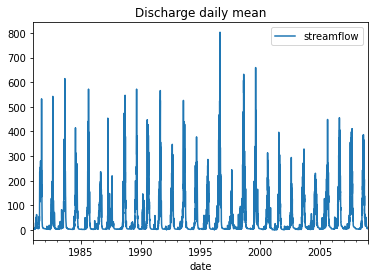

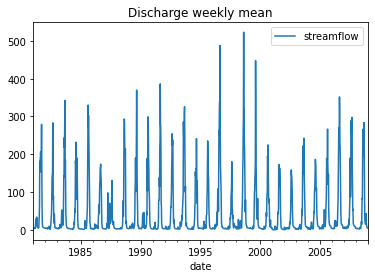

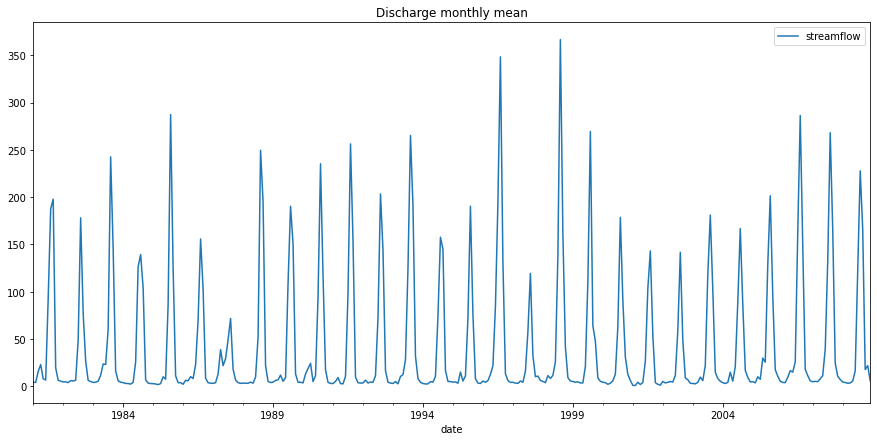

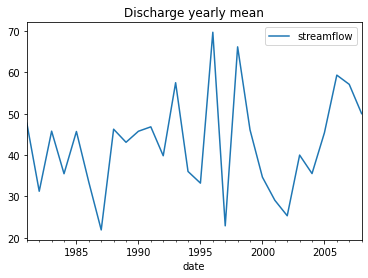

In [ ]:
sf_hom_D = sf_hom.resample('1D').mean()
sf_hom_W = sf_hom.resample('1W').mean()
sf_hom_M = sf_hom.resample('1M').mean()
sf_hom_Y = sf_hom.resample('1Y').mean()


sf_hom_D.plot(title="Discharge daily mean")
sf_hom_W.plot(title="Discharge weekly mean")
sf_hom_M.plot(title="Discharge monthly mean",figsize=(15,7))
sf_hom_Y.plot(title="Discharge yearly mean")

#Autocorrelation for streamflow at 3 different guaging stations

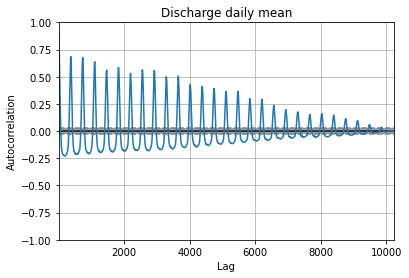

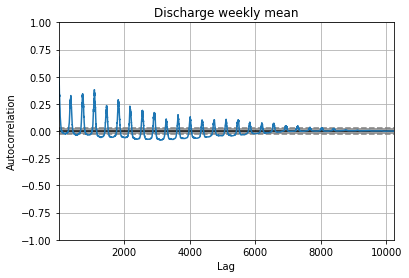

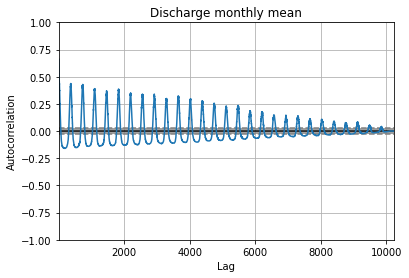

In [ ]:
pd.plotting.autocorrelation_plot(sf_hom['streamflow'])
#ax= pd.plotting.autocorrelation_plot(sf_hom['streamflow'])
#ax.set_xlim([0, 2000])
plt.title("Discharge daily mean")
plt.show()

pd.plotting.autocorrelation_plot(sf_akaki['streamflow'])
plt.title("Discharge weekly mean")
plt.show()

pd.plotting.autocorrelation_plot(sf_berga['streamflow'])
plt.title("Discharge monthly mean")
plt.show()

#from the graphs we can see that there is a corellation between the streamflows and their lags. But after 2000 days the correlation starts to decrease.
# The negative correlation between the time lags is mostly insignificant. This may be due to seasonality of the streamflow---meaning that in one
#season the streamflow may be high and on the next season it will be less 
# The plot also shows seasonality of the data 

In [ ]:
print(len(sf_akaki['streamflow']))
plot_acf(sf_akaki['streamflow'],lags=50)

plot_acf(sf_hom['streamflow'],lags=50)

plot_acf(sf_berga['streamflow'],lags=50)

10227


NameError: ignored

#Autocorrelation for preciptation at 11 guaging stations 

In [ ]:
#pd.plotting.autocorrelation_plot(pcp_aa['PCP'])
plot_acf(pcp_aa['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_hom['PCP'])
plot_acf(pcp_hom['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_asgori['PCP'])
plot_acf(pcp_asgori['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_sendefa['PCP'])
plot_acf(pcp_sendefa['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_tulubolo['PCP'])
plot_acf(pcp_tulubolo['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_aalem['PCP'])
plot_acf(pcp_aalem['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_boneya['PCP'])
plot_acf(pcp_boneya['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_kimoye['PCP'])
plot_acf(pcp_kimoye['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_sebeta['PCP'])
plot_acf(pcp_sebeta['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_guranda['PCP'])
plot_acf(pcp_guranda['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#pd.plotting.autocorrelation_plot(pcp_ginchi['PCP'])
plot_acf(pcp_ginchi['PCP'],lags=50)
plt.title("Preciptation daily")
plt.show()

#Autocorrelation for temperature at 11 guaging stations

In [ ]:
# pd.plotting.autocorrelation_plot(temp_aa['avg_temp'])
# plt.title("Temperature daily")
# plt.show()

#pd.plotting.autocorrelation_plot(temp_aa['avg_temp'])
plot_acf(temp_aa['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_hom['avg_temp'])
plot_acf(temp_hom['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_asgori['avg_temp'])
plot_acf(temp_asgori['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_sendefa['avg_temp'])
plot_acf(temp_sendefa['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_tulubolo['avg_temp'])
plot_acf(temp_tulubolo['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_aalem['avg_temp'])
plot_acf(temp_aalem['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_boneya['avg_temp'])
plot_acf(temp_boneya['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_kimoye['avg_temp'])
plot_acf(temp_kimoye['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_sebeta['avg_temp'])
plot_acf(temp_sebeta['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_guranda['avg_temp'])
plot_acf(temp_guranda['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()

#pd.plotting.autocorrelation_plot(temp_ginchi['avg_temp'])
plot_acf(temp_ginchi['avg_temp'],lags=50)
plt.title("temprature daily")
plt.show()


#Autocorrelation for Humudity at 11 guaging stations

In [ ]:
pd.plotting.autocorrelation_plot(hmd_tulubolo['HMD'])
plot_acf(hmd_tulubolo['HMD'],lags=100)
plt.title("humidity daily")
plt.show()

In [ ]:
#pd.plotting.autocorrelation_plot(hmd_ginchi['HMD'])
plot_acf(hmd_ginchi['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#the jumidity at ginchi station does not have any corelation and it is removed from our dataset since it will not help on prediction task.

In [ ]:
# pd.plotting.autocorrelation_plot(hmd_aa['HMD'])
# plt.title("humudirt daily")
# plt.show()

#pd.plotting.autocorrelation_plot(hmd_aa['HMD'])
plot_acf(hmd_aa['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_hom['HMD'])
plot_acf(hmd_hom['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_asgori['HMD'])
plot_acf(hmd_asgori['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_sendefa['HMD'])
plot_acf(hmd_sendefa['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_tulubolo['HMD'])
plot_acf(hmd_tulubolo['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_aalem['HMD'])
plot_acf(hmd_aalem['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_boneya['HMD'])
plot_acf(hmd_boneya['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_kimoye['HMD'])
plot_acf(hmd_kimoye['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_sebeta['HMD'])
plot_acf(hmd_sebeta['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_guranda['HMD'])
plot_acf(hmd_guranda['HMD'],lags=50)
plt.title("humidity daily")
plt.show()

#pd.plotting.autocorrelation_plot(hmd_ginchi['HMD'])
plot_acf(hmd_ginchi['HMD'],lags=50)
plt.title("humidity daily")
plt.show()


#Autocorrelation for wind at 11 guaging stations

In [ ]:
# pd.plotting.autocorrelation_plot(wnd_aa['WND'])
# plt.title("wind daily")
# plt.show()

#pd.plotting.autocorrelation_plot(wnd_aa['WND'])
plot_acf(wnd_aa['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_hom['WND'])
plot_acf(wnd_hom['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_asgori['WND'])
plot_acf(wnd_asgori['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_sendefa['WND'])
plot_acf(wnd_sendefa['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_tulubolo['WND'])
plot_acf(wnd_tulubolo['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_aalem['WND'])
plot_acf(wnd_aalem['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_boneya['WND'])
plot_acf(wnd_boneya['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_kimoye['WND'])
plot_acf(wnd_kimoye['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_sebeta['WND'])
plot_acf(wnd_sebeta['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_guranda['WND'])
plot_acf(wnd_guranda['WND'],lags=50)
plt.title("wind daily")
plt.show()

#pd.plotting.autocorrelation_plot(wnd_ginchi['WND'])
plot_acf(wnd_ginchi['WND'],lags=50)
plt.title("wind daily")
plt.show()


#Data Preparation for univariate input(i.e preciptation,temp,hum,wind @ 11 guaging stations and lagged discharge @ 3 guaging stations) and single step output (streamflow at target guaging station) Encoder-Decoder MODEL

#Supervised data generating function

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# n stations [prcn, prcn-1,...prc1]

#variable declaration

In [ ]:
look_back = 10 #Number of time-steps/ time-lags to see before predicting the current 
n_features = 1 # discharge @ target station which is hombole

In [ ]:
n_hours = look_back

#1. Training data preparation on year based slicing of pandas dataframe into trainig, validation and test, 20 years data used for training , 4 years data for validation and 4 years data for testing

#Dataframe for univariate single-step training

In [ ]:
raw = DataFrame()
#Temperature features 
# raw['temp_aa'] = temp_aa['avg_temp']
# raw['temp_hom'] = temp_hom['avg_temp']
# raw['temp_mojo'] = temp_mojo['avg_temp']
# raw['temp_sendefa'] = temp_sendefa['avg_temp']
# raw['temp_tulubolo'] = temp_tulubolo['avg_temp']
# #preciptation features
# raw['rain_aa'] = pcp_aa['PCP']
# raw['rain_hom'] = pcp_hom['PCP']
# raw['rain_mojo'] = pcp_mojo['PCP']
# raw['rain_sendefa'] = pcp_sendefa['PCP']
# raw['rain_tulubolo'] = pcp_tulubolo['PCP']
# #Humudity features 
# raw['hmd_aa'] = hmd_aa['HMD']
# raw['hmd_hom'] = hmd_hom['HMD']
# raw['hmd_mojo'] = hmd_mojo['HMD']
# raw['hmd_sendefa'] = hmd_sendefa['HMD']
# raw['hmd_tulubolo'] = hmd_tulubolo['HMD']
# #Wind features 
# raw['wnd_aa'] = wnd_aa['WND']
# raw['wnd_hom'] = wnd_hom['WND']
# raw['wnd_mojo'] = wnd_mojo['WND']
# raw['wnd_sendefa'] = wnd_sendefa['WND']
# raw['wnd_tulubolo'] = wnd_tulubolo['WND']

#Streamflow features
# raw['Q_akaki'] = sf_akaki['streamflow']
# raw['Q_mojo'] = sf_mojo['streamflow']
raw['Q_hom'] = sf_hom['streamflow']

values2 = raw.values
 

#Training data partition (1981 - 2000)

In [ ]:
raw_train= raw.loc['1981-01-01':'2000-12-31']
values_train = raw_train.values

#Validation data partition (2001 - 2004)

In [ ]:
raw_val = raw.loc['2001-01-01':'2004-12-31']
values_val = raw_val.values

#Test data partition (2004 - 2008)

In [ ]:
raw_test = raw.loc['2005-01-01':'2008-12-31']
values_test = raw_test.values

#Generating Supervised data for train, valid and test

In [ ]:
sup_train = series_to_supervised(values_train, n_hours, 1) 

print(sup_train.shape)

(7295, 11)


In [ ]:
sup_val = series_to_supervised(values_val, n_hours, 1) 

print(sup_val.shape)

(1451, 11)


In [ ]:
sup_test = series_to_supervised(values_test, n_hours, 1) 

print(sup_test.shape)

(1451, 11)


#Train, validation and Test split

In [ ]:
train = sup_train.values
val = sup_val.values
test = sup_test.values

In [ ]:
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
val_X, val_y = val[:, :n_obs], val[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
print(test_X.shape, len(test_X), test_y.shape)
print(val_X.shape, len(val_X), val_y.shape)

(7295, 10) 7295 (7295,)
(1451, 10) 1451 (1451,)
(1451, 10) 1451 (1451,)


#2. Training data prepartion by randomly classifying the whole data into train, validation and test

#Data frame after data is converted to supervised format for single-step output

In [ ]:
reframed = series_to_supervised(values2, n_hours, 1) 

print(reframed.shape)

(10217, 11)


In [ ]:
reframed

,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
10,4.238,4.238,4.238,4.238,4.238,4.238,4.238,4.121,4.121,4.121,4.121
11,4.238,4.238,4.238,4.238,4.238,4.238,4.121,4.121,4.121,4.121,4.121
12,4.238,4.238,4.238,4.238,4.238,4.121,4.121,4.121,4.121,4.121,4.121
13,4.238,4.238,4.238,4.238,4.121,4.121,4.121,4.121,4.121,4.121,4.121
14,4.238,4.238,4.238,4.121,4.121,4.121,4.121,4.121,4.121,4.121,4.121
...,...,...,...,...,...,...,...,...,...,...,...
10222,5.455,5.326,5.326,5.326,5.326,5.199,5.074,5.074,5.074,5.074,5.074
10223,5.326,5.326,5.326,5.326,5.199,5.074,5.074,5.074,5.074,5.074,5.074
10224,5.326,5.326,5.326,5.199,5.074,5.074,5.074,5.074,5.074,5.074,5.074
10225,5.326,5.326,5.199,5.074,5.074,5.074,5.074,5.074,5.074,5.074,5.074


#Train, Validation and Test split

In [ ]:
values_2 = reframed.values
TRAIN_SIZE = 0.8
n_train = int(len(values_2) * TRAIN_SIZE) 
train = values_2[:n_train, :]
eval = values_2[n_train:, :]

In [ ]:
TEST_SIZE = 0.5
n_val= int(len(eval) * TEST_SIZE) 
val = eval[:n_val, :]
test = eval[n_val:, :]

In [ ]:
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
val_X, val_y = val[:, :n_obs], val[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
print(test_X.shape, len(test_X), test_y.shape)
print(val_X.shape, len(val_X), val_y.shape)

(8173, 10) 8173 (8173,)
(1022, 10) 1022 (1022,)
(1022, 10) 1022 (1022,)


#Feature scaling (the next part of code will work for both approaches described above as 1) and 2) )

In [ ]:
# feature scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train = scaler_X.fit_transform(train_X)

scaler_Y = MinMaxScaler(feature_range=(0, 1))
Y_train = scaler_Y.fit_transform(train_y.reshape(-1,1))

In [ ]:
X_test = scaler_X.transform(test_X)
Y_test = scaler_Y.transform(test_y.reshape(-1,1))

X_val = scaler_X.transform(val_X)
Y_val = scaler_Y.transform(val_y.reshape(-1,1))

#Reshaping train, validation and test data into 3D shape since LSTM takes as input a data in the format (samples, time-step, sample_features)

In [ ]:
train_X2 = X_train.reshape((X_train.shape[0], n_hours, n_features))
test_X2 = X_test.reshape((X_test.shape[0], n_hours, n_features))
val_X2 = X_val.reshape((X_val.shape[0], n_hours, n_features))
print(train_X2.shape, train_y.shape, test_X2.shape, test_y.shape,val_X2.shape, val_y.shape)

(7295, 10, 1) (7295,) (1451, 10, 1) (1451,) (1451, 10, 1) (1451,)


In [ ]:
train_y2 = Y_train.reshape((Y_train.shape[0], 1, 1))
test_y2 = Y_test.reshape((Y_test.shape[0], 1, 1))
val_y2 = Y_val.reshape((Y_val.shape[0], 1, 1))
print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape,val_X2.shape, val_y2.shape)

(7295, 10, 1) (7295, 1, 1) (1451, 10, 1) (1451, 1, 1) (1451, 10, 1) (1451, 1, 1)


#1. Encoder-Decoder approach Model Setup. In this part a stacked LSTM/GRU encoder-decoder model is developed by feeding the decoder a zero input at the single step. A single step prediction model is developed where the length of decoder output sequence is one. I have used GRU stacked cells.

In [ ]:
keras.backend.clear_session()

layers = [100, 100] # Number of hidden neuros in each layer of the encoder and decoder

learning_rate = 0.001
decay = 0 # Learning rate decay
optimiser = tf.keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)

num_input_features = 1 # The dimensionality of the input at each time step.
num_output_features = 1 # The dimensionality of the output at each time step. 


loss = "mse" # Other loss functions are possible, see Keras documentation.

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

batch_size = 512
steps_per_epoch = 200 # batch_size * steps_per_epoch = total number of training examples
epochs = 15

input_sequence_length = 10 # Length of the sequence used by the encoder
target_sequence_length = 1 # Length of the sequence predicted by the decoder
num_steps_to_predict = 20 # Length to use when testing the model



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#Encoder_Decoder Setup using stacked LSTM and GRU

In [ ]:
# The Encoder
encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

encoder_cells = []
for hidden_neurons in layers:
    # encoder_cells.append(keras.layers.GRUCell(hidden_neurons,
    #                                           kernel_regularizer=regulariser,
    #                                           recurrent_regularizer=regulariser,
    #                                           bias_regularizer=regulariser))
    #Stacked LSTM
    encoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))
    

encoder = keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

encoder_states = encoder_outputs_and_states[1:]

In [ ]:
# The decoder 
decoder_inputs = keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    # decoder_cells.append(keras.layers.GRUCell(hidden_neurons,
    #                                           kernel_regularizer=regulariser,
    #                                           recurrent_regularizer=regulariser,
    #                                           bias_regularizer=regulariser))
    #Stacked LSTM
    decoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                              kernel_regularizer=regulariser,
                                              recurrent_regularizer=regulariser,
                                              bias_regularizer=regulariser))

decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

decoder_outputs = decoder_outputs_and_states[0]

# dropout = Dropout(rate=0.25)
# decoder_outputs = dropout(decoder_outputs)

decoder_dense = keras.layers.Dense(num_output_features,
                                   activation='linear',
                                   kernel_regularizer=regulariser,
                                   bias_regularizer=regulariser)

decoder_outputs = decoder_dense(decoder_outputs)

#In the following cells an Encoder-Decoder impelementation using Bidirectional LSTM is demonstrated.

In [ ]:
# The encoder
encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')

#encoder_lstm1 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
encoder_lstm1 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
#encoder_lstm1_output,forward_h1,forward_c1,backward_h1,backward_c1 = encoder_lstm1(encoder_inputs) # For LSTM based
encoder_lstm1_output,forward_h1,backward_h1= encoder_lstm1(encoder_inputs) # For GRU based

#encoder_lstm2 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
encoder_lstm2 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
#encoder_lstm2_output,forward_h2,forward_c2,backward_h2,backward_c2 = encoder_lstm2(encoder_lstm1_output)
encoder_lstm2_output,forward_h2,backward_h2= encoder_lstm2(encoder_lstm1_output)

# state_h = Concatenate()([forward_h2,backward_h2])
# state_c = Concatenate()([forward_c2,backward_c2])
#encoder_states = [state_h, state_c]

#states = [forward_h2,forward_c2,backward_h2,backward_c2]
states = [forward_h2,backward_h2]



#The Decoder part 
decoder_inputs = keras.layers.Input(shape=(None, 1))

#decoder_lstm = LSTM(16, return_sequences=True, return_state=True, name='decoder_lstm')
#decoder_lstm_output,forward_h,forward_c = decoder_lstm(decoder_inputs,initial_state=encoder_states)
#decoder_lstm1 = Bidirectional(LSTM(50,return_state=True,return_sequences=True))
decoder_lstm1 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
#decoder_lstm1_output,forward_h1,forward_c1,backward_h1,backward_c1 = decoder_lstm1(decoder_inputs,initial_state=states)
decoder_lstm1_output,forward_h1,backward_h1 = decoder_lstm1(decoder_inputs,initial_state=states)

#decoder_lstm2 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
decoder_lstm2 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
#decoder_lstm2_output,forward_h2,forward_c2,backward_h2,backward_c2 = decoder_lstm2(decoder_lstm1_output)
decoder_lstm2_output,forward_h2,backward_h2 = decoder_lstm2(decoder_lstm1_output)

decoder_outputs = decoder_lstm2_output

# dropout = Dropout(rate=0.25)
# decoder_outputs = dropout(decoder_outputs)

decoder_dense = keras.layers.Dense(num_output_features,
                                  activation='linear',
                                  kernel_regularizer=regulariser,
                                  bias_regularizer=regulariser)


decoder_outputs = decoder_dense(decoder_lstm2_output)


#These are the decoder input values which are set as zero. Since the decoder has sequence length of one and the input feature is only the streamflow data the the feature size is also one. Thus the shape of the decoder input will be (samples, 1,1)

In [ ]:
train_decoder_input_data = np.zeros((7295,  1, 1))

In [ ]:
val_decoder_input_data = np.zeros((1451,  1, 1))

In [ ]:
test_decoder_input_data = np.zeros((1451,  1, 1))

#Training the Model

In [ ]:
model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
#model.summary()
model.compile(optimizer=optimiser, loss=loss)

In [ ]:
history2 = model.fit([train_X2,train_decoder_input_data], train_y2, epochs=50, batch_size=100, validation_data=([val_X2,val_decoder_input_data], val_y2), verbose=1, shuffle=False)

#Plotting the loss curve

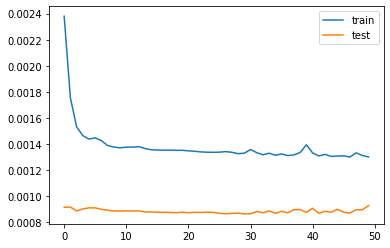

In [ ]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

#Prediction result on test dataset

In [ ]:
y_test_predicted = model.predict([test_X2,test_decoder_input_data])
pred= tf.reshape(y_test_predicted, [1451, 1])
orig=tf.reshape(test_y2, [1451, 1])

inv_yhat2 = scaler_Y.inverse_transform(pred)
inv_y2 = scaler_Y.inverse_transform(orig)

In [ ]:
pred

#RMSE, MAE and NSE value of the Model

In [ ]:
rmse2 = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Test RMSE: %.4f' % rmse2)

Test RMSE: 27.8188


In [ ]:
# mae of zero means there is no error or the predicted value perfectly fits the original data
mae= mean_absolute_error(inv_y2, inv_yhat2)
print('Test mae: %.4f' % mae)

Test mae: 14.8439


In [ ]:
nse = 1-(np.sum(np.power((inv_y2-inv_yhat2),2))/np.sum(np.power((inv_y2-inv_y2.mean()),2)))
print('Test NSE: %.4f' % nse)

Test NSE: 0.8972


#Ploting prediction result Vs actual value

inv_y2 (OBS) max: 455.706  versus inv_yhat2 (SIM) max: 351.1172705383301


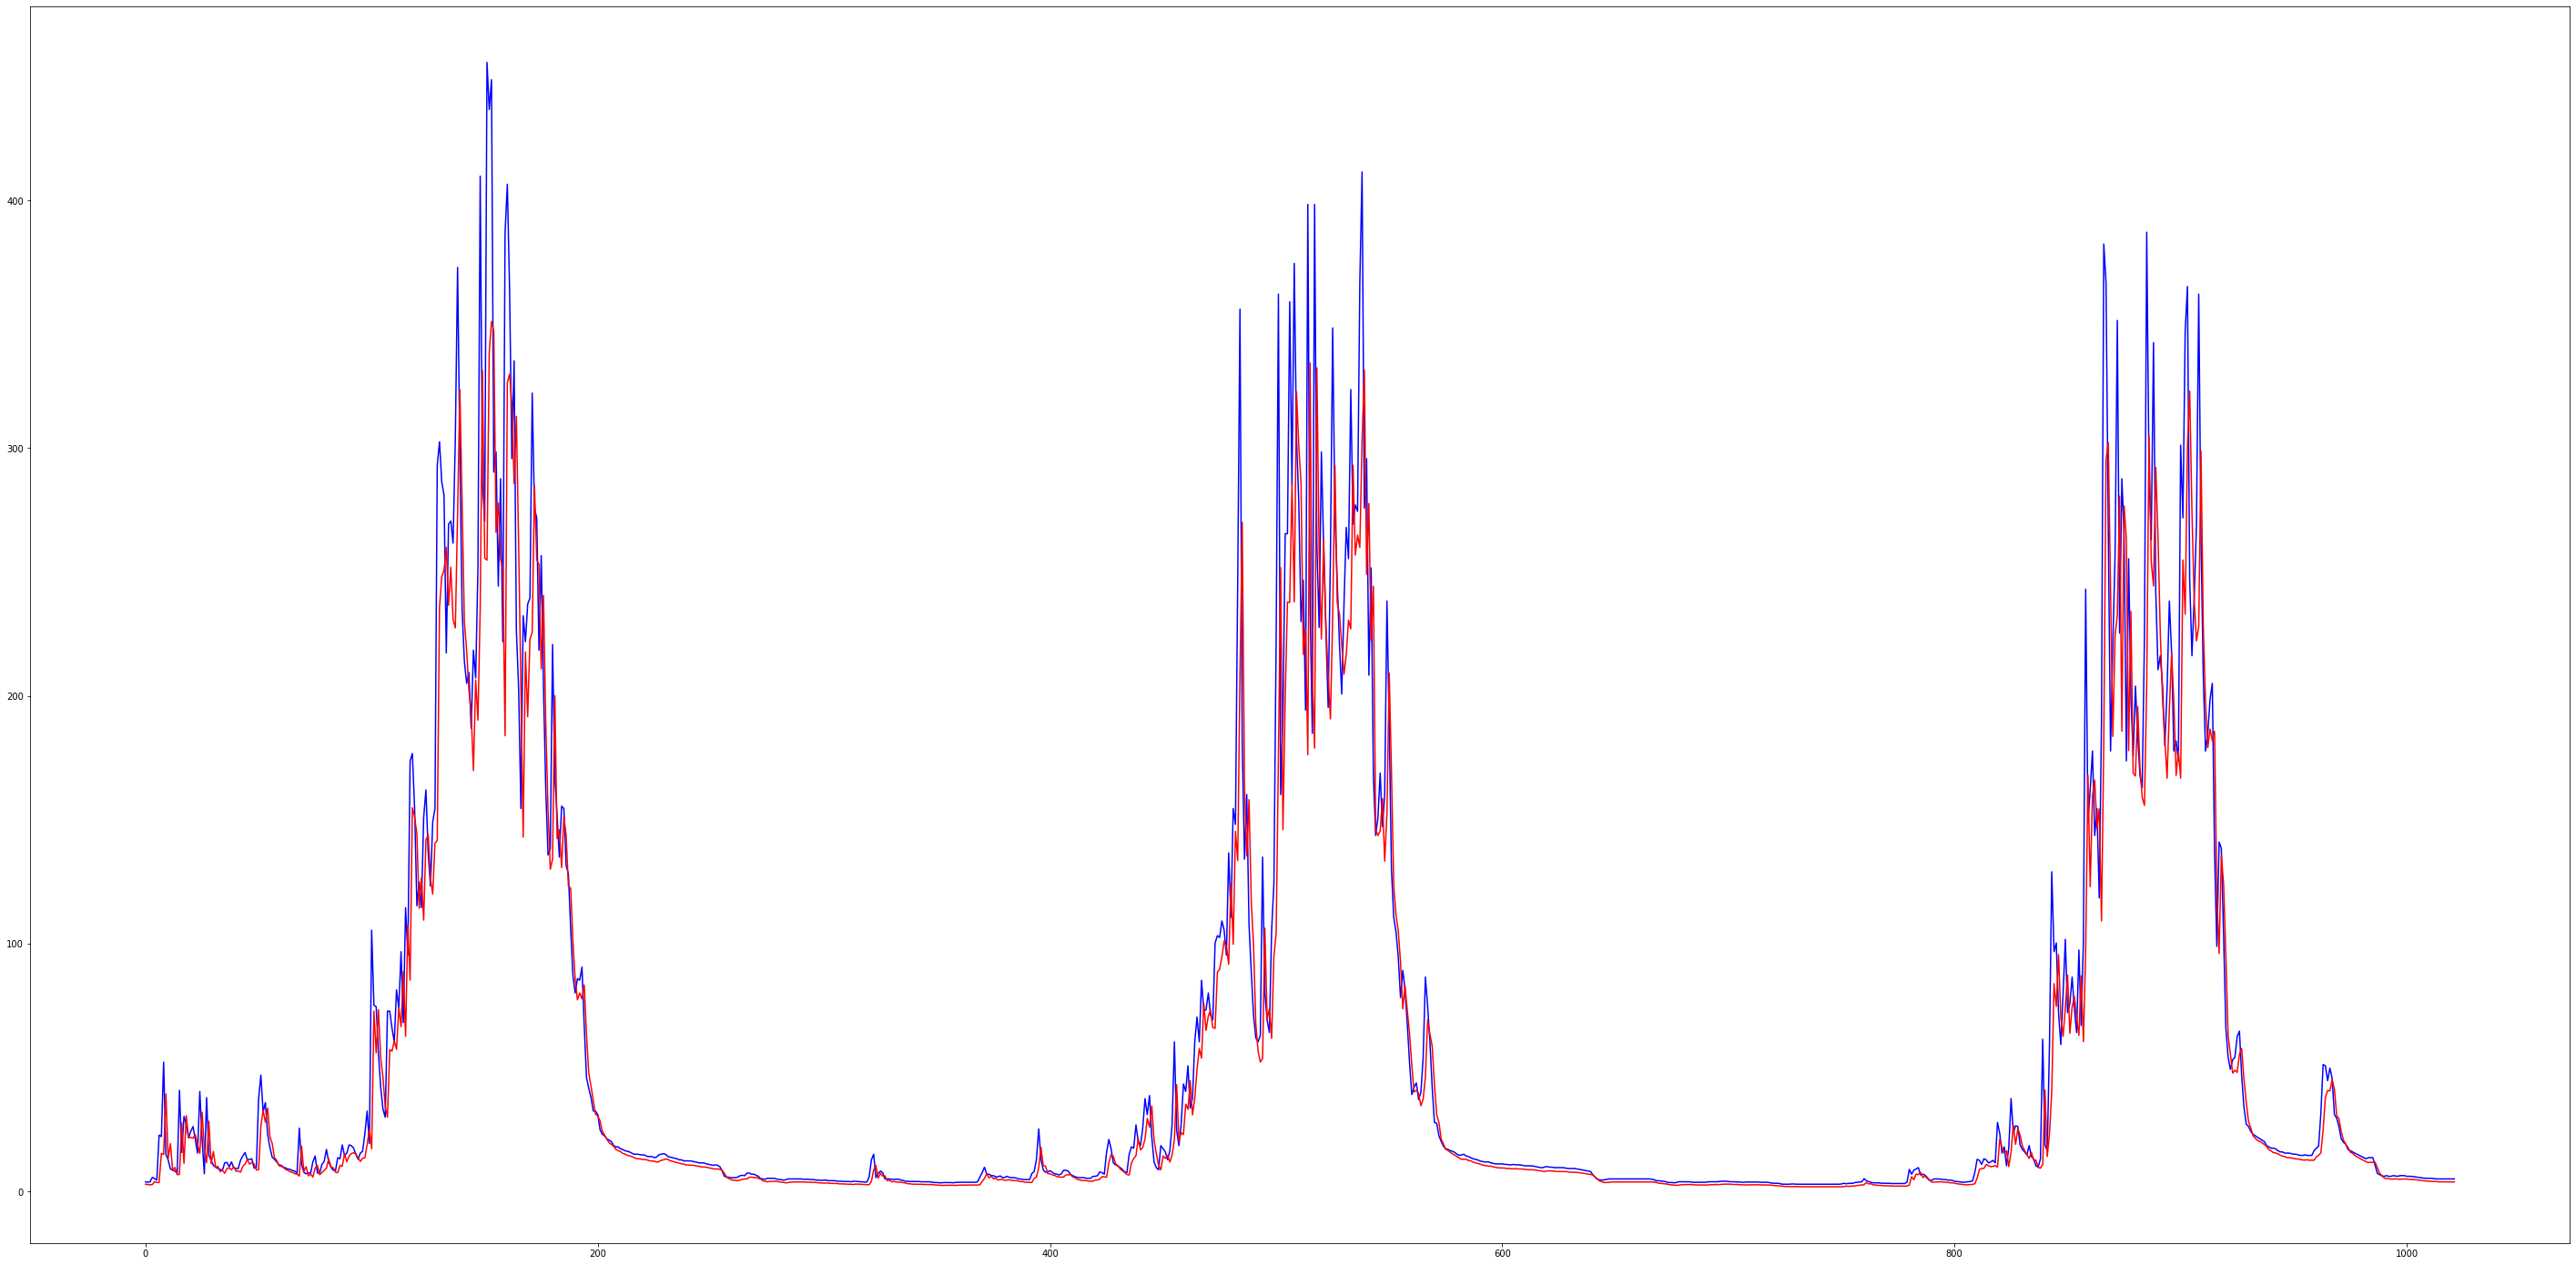

In [ ]:
print('inv_y2 (OBS) max:',np.max(inv_y2),' versus inv_yhat2 (SIM) max:',np.max(inv_yhat2))
plt.figure(figsize=(50,25))
plt.plot(inv_y2, color='blue')
plt.plot(inv_yhat2,color='red')
plt.show()

#2. In the next section I implement an encoder-decoder model for single step but this time the decoder input will be the last encoder output. The last encoder output is used as an initial token of the decoder. I have used single layer LSTM and stacked LSTM/GRU cells.

In [ ]:
def _create_stacked_rnn_cells():
    """
   Create a `layers_stacked_count` amount of GRU cells and stack them on top of each other.
   They have a `hidden_dim` number of neuron layer size.

   :param step: The base Neuraxle step for TensorFlow v2 (Tensorflow2ModelStep)
    :return: list of gru cells
    """
    cells = []
    for _ in range(2): # modifiy this one
        cells.append(GRUCell(50, kernel_regularizer=regulariser, recurrent_regularizer=regulariser, bias_regularizer=regulariser))
        #cells.append(LSTMCell(100, kernel_regularizer=regulariser, recurrent_regularizer=regulariser, bias_regularizer=regulariser))
    
    return cells

In [ ]:
def create_hard_coded_decoder_input_model(batch_size):
  # The encoder
  encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')
  encoder_lstm = RNN(cell=_create_stacked_rnn_cells(), return_sequences=False, return_state=True)
  #encoder_lstm = GRU(16, return_state=True,  name='encoder_lstm')# if you use GRU and LSTM without the keras RNN API their return values are different.
                                                                  # in the case of LSTM it returns 3 values the output, the hidden sate and cell state where as in the cae of
                                                                  # GRU it returns 2 values only i.e we do not have the cell state.
  
  encoder_outputs, state_h,state_c = encoder_lstm(encoder_inputs)
  
  encoder_output_densed = Dense(num_input_features,  name='encoder_dense')(encoder_outputs)
  print(encoder_output_densed.shape)
  
  decoder_input_data = tf.expand_dims(encoder_output_densed, axis=1)
  print(decoder_input_data.shape)
  
  states = [state_h, state_c]

  #The Decoder part 
  decoder_inputs = Input(shape=(1, num_input_features))
  
  decoder_lstm = RNN(cell=_create_stacked_rnn_cells(), return_sequences=True, return_state=True)
  #decoder_lstm = LSTM(16, return_sequences=True, return_state=True, name='decoder_lstm')
  
  decoder_dense = Dense(num_output_features,  name='decoder_dense')
  
  all_outputs = []
  inputs = decoder_input_data

  sequence_length = 1
  for _ in range(sequence_length):
      
      outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
      
      outputs = decoder_dense(outputs)
      all_outputs.append(outputs)
      inputs = outputs
      states = [state_h, state_c]
      

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  
  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer=optimiser, loss='mse', metrics=['accuracy'])
  return model

#Using Bi-LSTM or Bi-GRU 

In [ ]:
def create_hard_coded_decoder_input_model(batch_size):
  # The encoder
  encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')

  #encoder_lstm1 = Bidirectional(LSTM(50,return_state=True,return_sequences=True))
  encoder_lstm1 = Bidirectional(GRU(100,return_state=True,return_sequences=True))
  #encoder_lstm1_output,forward_h1,forward_c1,backward_h1,backward_c1 = encoder_lstm1(encoder_inputs) # For LSTM based
  encoder_lstm1_output,forward_h1,backward_h1= encoder_lstm1(encoder_inputs) # For GRU based

  #encoder_lstm2 = Bidirectional(LSTM(50,return_state=True,return_sequences=False))
  encoder_lstm2 = Bidirectional(GRU(100,return_state=True,return_sequences=False))
  #encoder_lstm2_output,forward_h2,forward_c2,backward_h2,backward_c2 = encoder_lstm2(encoder_lstm1_output)
  encoder_lstm2_output,forward_h2,backward_h2= encoder_lstm2(encoder_lstm1_output)

  encoder_output_densed = Dense(num_input_features,  name='encoder_dense')(encoder_lstm2_output)


  decoder_input_data = tf.expand_dims(encoder_output_densed, axis=1)

  #states = [forward_h2,forward_c2,backward_h2,backward_c2]
  states = [forward_h2,backward_h2]

  #The Decoder part 
  decoder_inputs=Input(shape=(1, num_input_features), name='encoder_inputs')


  decoder_lstm1 = Bidirectional(GRU(100,return_state=True,return_sequences=True))


  decoder_dense = Dense(num_output_features, activation='linear',  kernel_regularizer=regulariser, bias_regularizer=regulariser, name='decoder_dense')

  all_outputs = []
  inputs = decoder_input_data

  sequence_length = 1
  for _ in range(sequence_length):
      
      outputs, forward_state_h, backward_state_h = decoder_lstm1(inputs, initial_state=states)
      #outputs, forward_h,forward_c,backward_h,backward_c = decoder_lstm1(inputs, initial_state=states)
      
      outputs = decoder_dense(outputs)
      all_outputs.append(outputs)
      inputs = outputs
      states = [forward_state_h, backward_state_h]
      #states = [forward_h,forward_c,backward_h,backward_c]
      

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer=optimiser, loss='mse', metrics=['accuracy'])
  return model


#Training the Model

In [ ]:
model_encoder_decoder=create_hard_coded_decoder_input_model(batch_size=batch_size)
#model_encoder_decoder.summary()

In [ ]:
history2 = model_encoder_decoder.fit(train_X2, train_y2, epochs=50, batch_size=100, validation_data=(val_X2, val_y2), verbose=1, shuffle=False)

#Plotting the loss curve

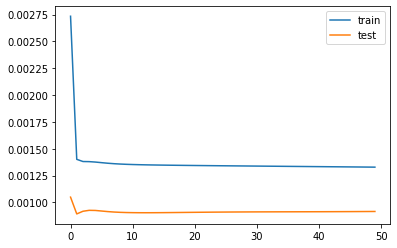

In [ ]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

#prediction on test set data

In [ ]:
y_test_predicted = model_encoder_decoder.predict(test_X2)
pred= tf.reshape(y_test_predicted, [1451, 1])
orig=tf.reshape(test_y2, [1451, 1])

inv_yhat2 = scaler_Y.inverse_transform(pred)
inv_y2 = scaler_Y.inverse_transform(orig)

#RMSE value of the Model

In [ ]:
rmse2 = sqrt(mean_squared_error(inv_yhat2, inv_y2))
print('Test RMSE: %.4f' % rmse2)

Test RMSE: 27.6640


In [ ]:
# mae of zero means there is no error or the predicted value perfectly fits the original data
mae= mean_absolute_error(inv_y2, inv_yhat2)
print('Test mae: %.4f' % mae)

Test mae: 13.3592


In [ ]:
nse = 1-(np.sum(np.power((inv_y2-inv_yhat2),2))/np.sum(np.power((inv_y2-inv_y2.mean()),2)))
print('Test NSE: %.4f' % nse)

Test NSE: 0.8983


#Ploting prediction result Vs actual value

In [ ]:
print('inv_y2 (OBS) max:',np.max(inv_y2),' versus inv_yhat2 (SIM) max:',np.max(inv_yhat2))
plt.figure(figsize=(50,25))
plt.plot(inv_y2, color='blue')
plt.plot(inv_yhat2,color='red')
plt.show()

#3. In this section I implement an encoder-decoder model where the input will be the last encoder output without being fed to a dense layer. If the decoder output sequence length is more than one the encoder output is Repeated based on the number of decoder output sequence length. Then the repeated encoder output will be fed as an input to the decoder.

# This function is used to create a stacked GRU/LSTM cells.

In [ ]:
def _create_stacked_rnn_cells():
    """
   Create a `layers_stacked_count` amount of GRU/LSTM cells and stack them on top of each other.
   They have a `hidden_dim` number of neuron layer size.

   :param step: The base Neuraxle step for TensorFlow v2 (Tensorflow2ModelStep)
    :return: list of gru/lstm cells
    """
    cells = []
    for _ in range(2): # modifiy this one
        cells.append(GRUCell(50, kernel_regularizer=regulariser, recurrent_regularizer=regulariser, bias_regularizer=regulariser))
        #cells.append(LSTMCell(100, kernel_regularizer=regulariser, recurrent_regularizer=regulariser, bias_regularizer=regulariser))
    
    return cells

In [ ]:
def create_hard_coded_decoder_input_model2(batch_size):
  # The encoder
  encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')
  encoder_lstm = RNN(cell=_create_stacked_rnn_cells(), return_sequences=False, return_state=True)
  #encoder_lstm = LSTM(numberOfLSTMunits, return_state=True,  name='encoder_lstm')
  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
  print(encoder_outputs.shape)

  last_encoder_output = tf.expand_dims(encoder_outputs, axis=1)
  print(last_encoder_output.shape)
  replicated_last_encoder_output = tf.repeat(
        input=last_encoder_output,
        repeats=1, # The number of repeatitions will be dependent on the decoder output sequence length
        axis=1
    )
  print(replicated_last_encoder_output.shape)
  
  states = [state_h, state_c]
  
  #The Decoder
  decoder_inputs = Input(shape=(1, num_input_features))
  
  decoder_lstm = RNN(cell=_create_stacked_rnn_cells(), return_sequences=True, return_state=True)
  
  outputs, state_h, state_c = decoder_lstm(replicated_last_encoder_output, initial_state=states)
  
  decoder_dense = Dense(num_output_features,  name='decoder_dense')
  decoder_outputs = decoder_dense(outputs)

  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer=optimiser, loss='mse', metrics=['accuracy'])
  return model

#Encoder-decoder implementation for variable length prediction

In [ ]:
def create_hard_coded_decoder_input_model(batch_size):
  # The encoder
  encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')
  encoder_lstm = RNN(cell=_create_stacked_rnn_cells(), return_sequences=False, return_state=True)
  #encoder_lstm = GRU(16, return_state=True,  name='encoder_lstm')# if you use GRU and LSTM without the keras RNN API their return values are different. in the case of LSTM it returns 3 values the output, the hidden sate and cell state where as in the cae of GRU it returns 2 values only i.e we do not have the cell state.
  
  encoder_outputs, state_h,state_c = encoder_lstm(encoder_inputs)

  last_encoder_output = tf.expand_dims(encoder_outputs, axis=1)
  replicated_last_encoder_output = tf.repeat(
        input=last_encoder_output,
        repeats=1, # The number of repeatitions will be dependent on the decoder output sequence length
        axis=1
    )
  
  

  
  states = [state_h, state_c]

  #The Decoder part 
  decoder_inputs = Input(shape=(1, num_input_features))
  
  decoder_lstm = RNN(cell=_create_stacked_rnn_cells(), return_sequences=True, return_state=True)
  #decoder_lstm = LSTM(16, return_sequences=True, return_state=True, name='decoder_lstm')
  
  decoder_dense = Dense(num_output_features,  name='decoder_dense')
  
  all_outputs = []
  inputs = replicated_last_encoder_output

  sequence_length = 1
  for _ in range(sequence_length):
      
      outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
      
      outputs = decoder_dense(outputs)
      all_outputs.append(outputs)
      inputs = outputs
      states = [state_h, state_c]
      

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  
  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer=optimiser, loss='mse', metrics=['accuracy'])
  return model

#Using Bi-LSTM and Bi-GRU for the encoder decoder setup with last encoder output being used as a decoder input

In [ ]:
def create_hard_coded_decoder_input_model(batch_size):
  # The encoder
  encoder_inputs = Input(shape=(input_sequence_length, num_input_features), name='encoder_inputs')

  encoder_lstm1 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))
  #encoder_lstm1 = Bidirectional(GRU(50,return_state=True,return_sequences=True))
  encoder_lstm1_output,forward_h1,forward_c1,backward_h1,backward_c1 = encoder_lstm1(encoder_inputs) # For LSTM based
  #encoder_lstm1_output,forward_h1,backward_h1= encoder_lstm1(encoder_inputs) # For GRU based

  encoder_lstm2 = Bidirectional(LSTM(100,return_state=True,return_sequences=False))
  #encoder_lstm2 = Bidirectional(GRU(50,return_state=True,return_sequences=False))
  encoder_lstm2_output,forward_h2,forward_c2,backward_h2,backward_c2 = encoder_lstm2(encoder_lstm1_output)
  #encoder_lstm2_output,forward_h2,backward_h2= encoder_lstm2(encoder_lstm1_output)


  last_encoder_output = tf.expand_dims(encoder_lstm2_output, axis=1)
  replicated_last_encoder_output = tf.repeat(
        input=last_encoder_output,
        repeats=1, # The number of repeatitions will be dependent on the decoder output sequence length
        axis=1
    )
  


  states = [forward_h2,forward_c2,backward_h2,backward_c2]
  #states = [forward_h2,backward_h2]

  #The Decoder part 
  decoder_inputs=Input(shape=(1, num_input_features), name='encoder_inputs')

  #decoder_lstm1 = Bidirectional(GRU(50,return_state=True,return_sequences=True))
  decoder_lstm1 = Bidirectional(LSTM(100,return_state=True,return_sequences=True))

  decoder_dense = Dense(num_output_features, activation='linear',  kernel_regularizer=regulariser, bias_regularizer=regulariser, name='decoder_dense')

  all_outputs = []
  inputs = replicated_last_encoder_output

  sequence_length = 1
  for _ in range(sequence_length):
      
      #outputs, forward_state_h, backward_state_h = decoder_lstm1(inputs, initial_state=states)
      outputs, forward_h,forward_c,backward_h,backward_c = decoder_lstm1(inputs, initial_state=states)
      
      outputs = decoder_dense(outputs)
      all_outputs.append(outputs)
      inputs = outputs
      #states = [forward_state_h, backward_state_h]
      states = [forward_h,forward_c,backward_h,backward_c]
      

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer=optimiser, loss='mse', metrics=['accuracy'])
  return model


#Training the Model

In [ ]:
model_encoder_decoder=create_hard_coded_decoder_input_model(batch_size=batch_size)
#model_encoder_decoder.summary()

In [ ]:
history2 = model_encoder_decoder.fit(train_X2, train_y2, epochs=50, batch_size=100, validation_data=(val_X2, val_y2), verbose=1, shuffle=False)

Epoch 1/50
73/73 [==============================] - 11s 39ms/step - loss: 0.0050 - accuracy: 2.7416e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 2/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0025 - accuracy: 2.7416e-04 - val_loss: 8.1515e-04 - val_accuracy: 0.0000e+00
Epoch 3/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0016 - accuracy: 2.7416e-04 - val_loss: 7.6374e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0015 - accuracy: 2.7416e-04 - val_loss: 7.7197e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0015 - accuracy: 2.7416e-04 - val_loss: 7.4668e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0015 - accuracy: 2.7416e-04 - val_loss: 7.4190e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0014 - acc

#Plotting the loss curve

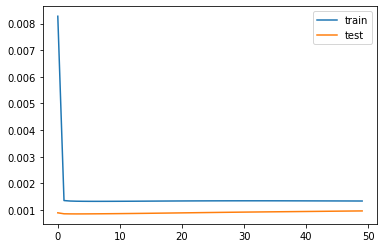

In [ ]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

#Prediction result on test dataset

In [ ]:
y_test_predicted = model_encoder_decoder.predict(test_X2)
pred= tf.reshape(y_test_predicted, [1451, 1])
orig=tf.reshape(test_y2, [1451, 1])

inv_yhat2 = scaler_Y.inverse_transform(pred)
inv_y2 = scaler_Y.inverse_transform(orig)

#RMSE value of the Model

In [ ]:
rmse2 = sqrt(mean_squared_error(inv_y2, inv_yhat2))
print('Test RMSE: %.4f' % rmse2)

Test RMSE: 27.7926


In [ ]:
# mae of zero means there is no error or the predicted value perfectly fits the original data
mae= mean_absolute_error(inv_y2, inv_yhat2)
print('Test mae: %.4f' % mae)

Test mae: 12.8355


In [ ]:
nse = 1-(np.sum(np.power((inv_y2-inv_yhat2),2))/np.sum(np.power((inv_y2-inv_y2.mean()),2)))
print('Test NSE: %.4f' % nse)

Test NSE: 0.8974


#Ploting prediction result Vs actual value

inv_y2 (OBS) max: 455.706  versus inv_yhat2 (SIM) max: 347.9128101612926


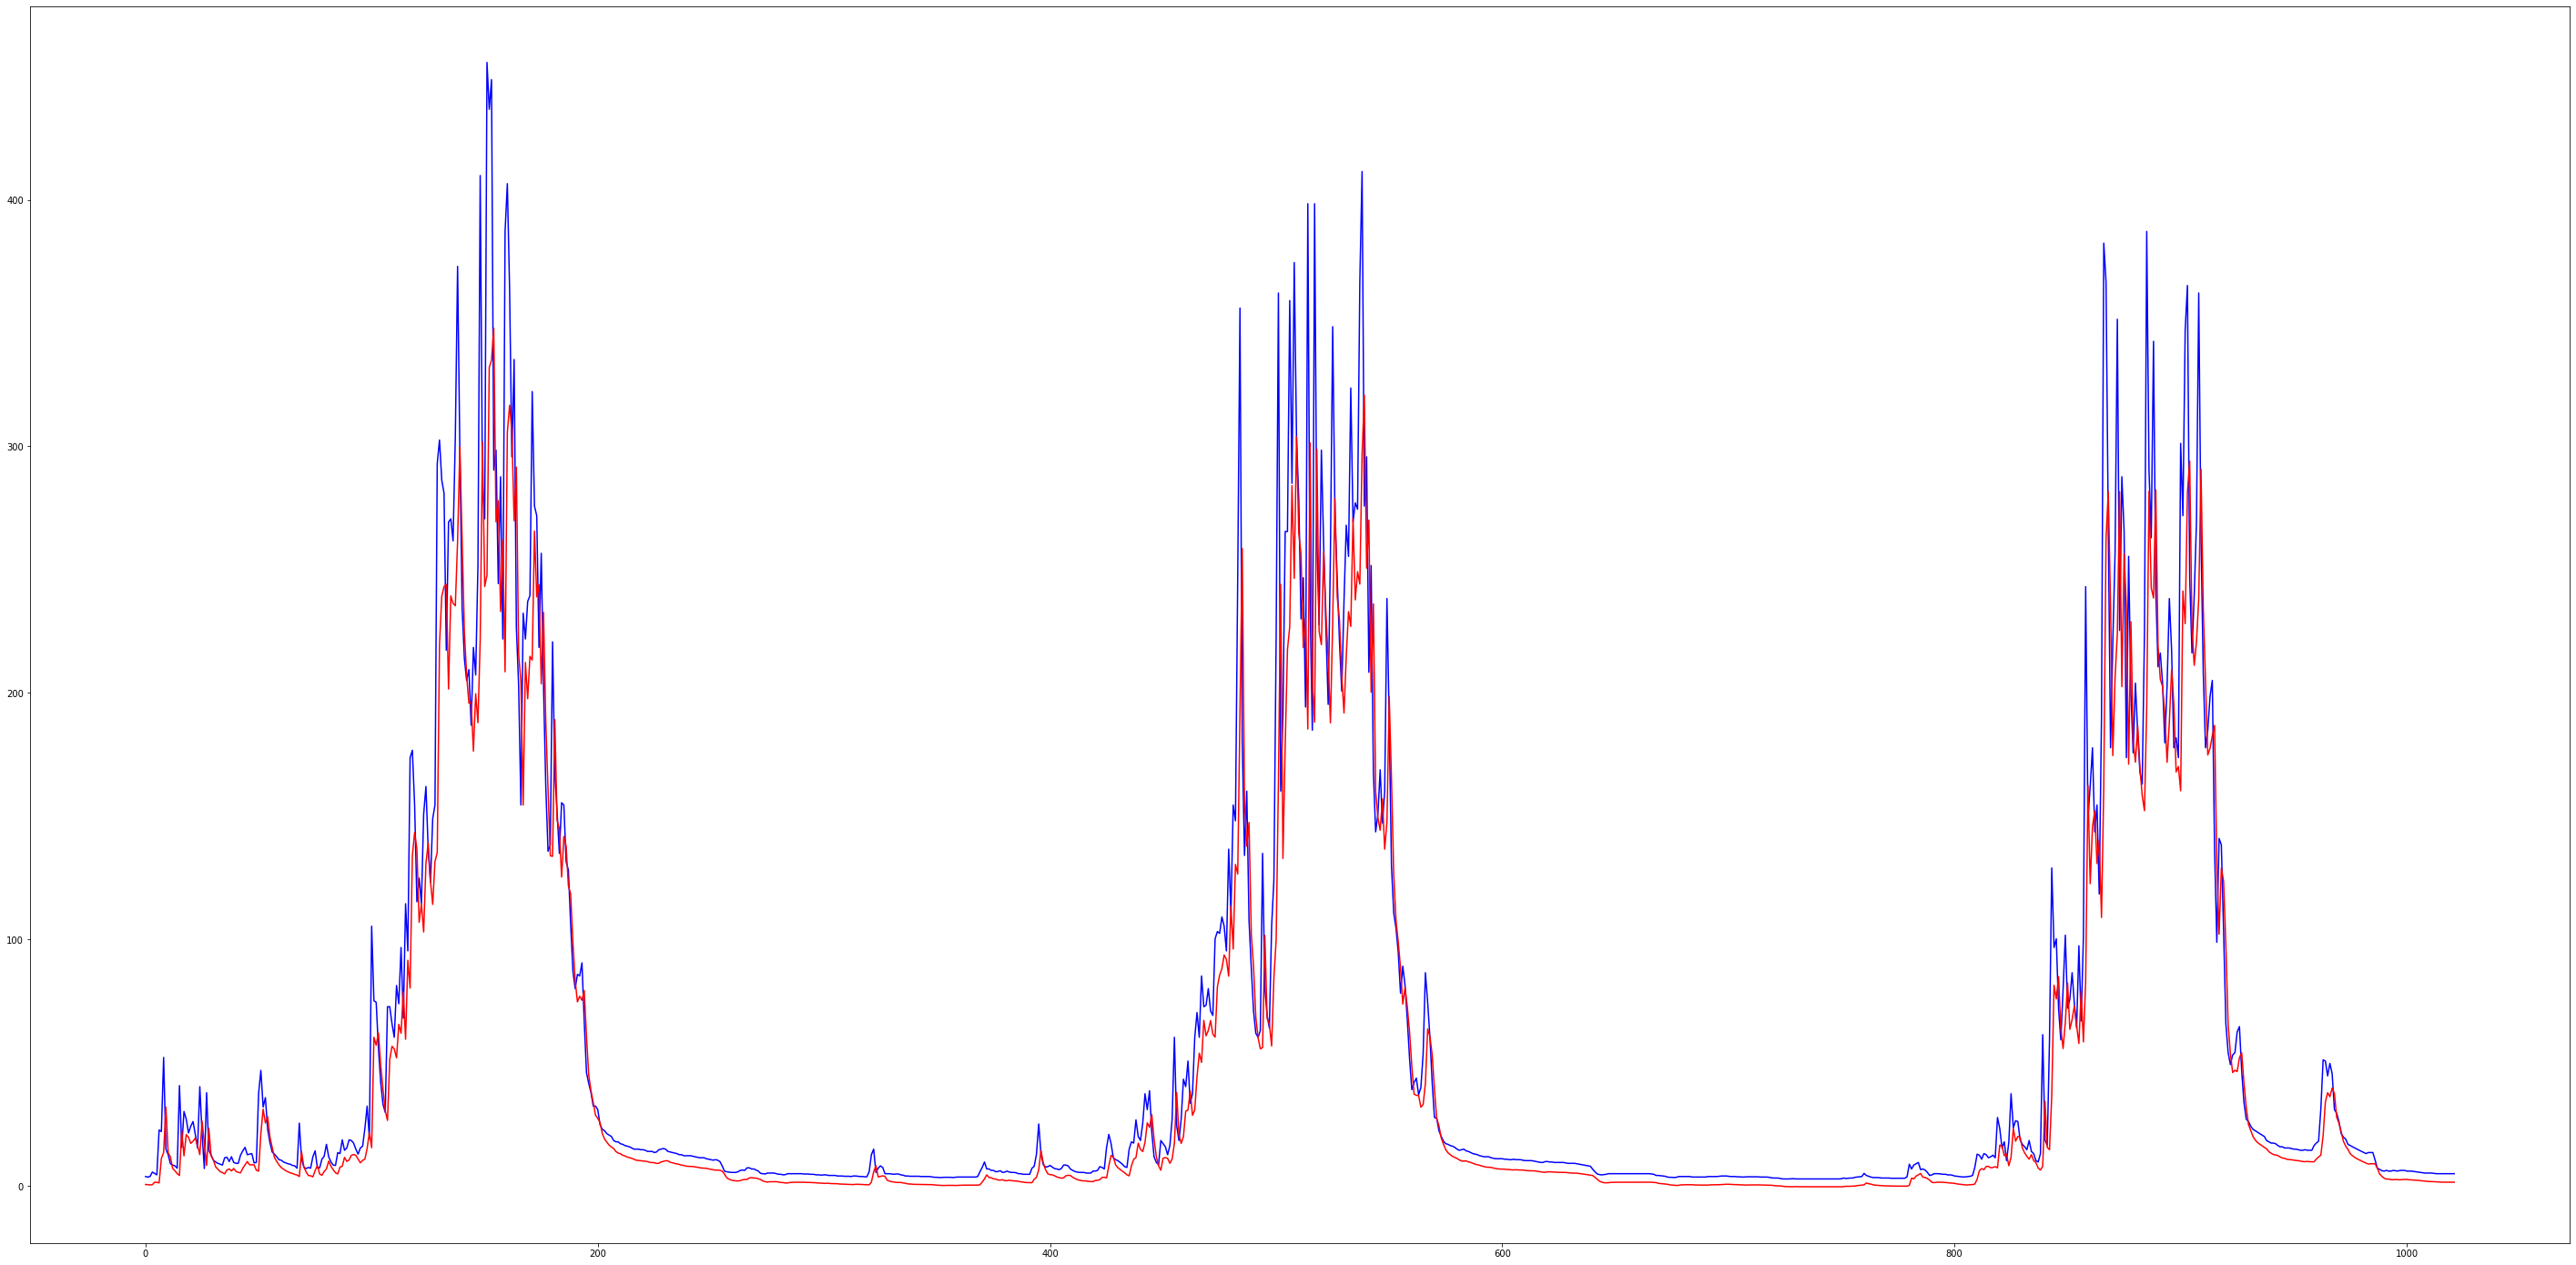

In [ ]:
print('inv_y2 (OBS) max:',np.max(inv_y2),' versus inv_yhat2 (SIM) max:',np.max(inv_yhat2))
plt.figure(figsize=(50,25))
plt.plot(inv_y2, color='blue')
plt.plot(inv_yhat2,color='red')
plt.show()